In [13]:
import warnings
import pandas as pd
import numpy as np
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [14]:
df_path = 'C:\imbalance_forecast\data\df_nord_h_project.csv'
df_nord = pd.read_csv(df_path, index_col=0, parse_dates=True)

# Check for duplicate timestamps in the index and remove duplicates
df_nord = df_nord[~df_nord.index.duplicated(keep='first')]

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\samueledelia\AppData\Local\Temp\3\ipykernel_11268\2431135960.py:1: SyntaxWarning: invalid escape sequence '\i'
  df_path = 'C:\imbalance_forecast\data\df_nord_h_project.csv'


In [15]:
df_nord.tail(24)

,SBIL_MWH,SBIL_MWH_lag1,SBIL_MWH_lag2,SBIL_MWH_lag3,SBIL_MWH_lag24,UNBALANCE_IDRO-NON-PROGRAMMABILE_MACRONORD,UNBALANCE_IDRO-PROGRAMMABILE_NORD,UNBALANCE_SOLARE_NORD
ORAINI,,,,,,,,
2024-12-05 16:00:00,169.431,-120.090,-247.940,351.223,226.921,-116803.56,-21139.06,-29055.297
2024-12-05 17:00:00,452.233,169.431,-120.090,-247.940,-406.558,-302.63,19919.95,-2491.804
2024-12-05 18:00:00,447.653,452.233,169.431,-120.090,54.228,-159134.78,531.62,3.600
2024-12-05 19:00:00,19.644,447.653,452.233,169.431,29.527,-338433.69,6449.04,3.600
2024-12-05 20:00:00,209.263,19.644,447.653,452.233,-74.906,-240458.20,-444.91,3.600
2024-12-05 21:00:00,178.897,209.263,19.644,447.653,18.710,-70571.94,2922.29,3.600
2024-12-05 22:00:00,2007.662,178.897,209.263,19.644,-11.808,-2431.04,4906.67,3.600
2024-12-05 23:00:00,74.294,2007.662,178.897,209.263,103.810,-28557.51,-4.72,3.600
2024-12-06 00:00:00,-22.369,74.294,2007.662,178.897,-66.642,29387.11,-65805.89,3.600


In [16]:
# Check for duplicate timestamps in the index and remove duplicates
df_nord = df_nord[~df_nord.index.duplicated(keep='first')]

# Define past, future, and present covariates
past_covariates = []#df_nord[['TOTAL_LOAD_MW', 'FORECAST_TOTAL_LOAD_MW']]

future_covariates = [] #df_nord[['MGP_NORD_PURCHASES', 'MGP_NORD_SALES']]

present_covariates = df_nord[['SBIL_MWH_lag1', 'SBIL_MWH_lag2', 'SBIL_MWH_lag3', 'SBIL_MWH_lag24', 'UNBALANCE_IDRO-NON-PROGRAMMABILE_MACRONORD', 'UNBALANCE_IDRO-PROGRAMMABILE_NORD', 'UNBALANCE_SOLARE_NORD']]
target = df_nord['SBIL_MWH']


In [17]:
# Shift target to predict the second step ahead (t+2)
#df_nord['SBIL_MWH_t+2'] = df_nord['SBIL_MWH'].shift(-2)

# Drop rows with NaN values resulting from the shift
df_nord = df_nord.dropna()

# Features (X) and Target (y)
#X = df_nord.drop(columns=['SBIL_MWH', 'SBIL_MWH_t+2'])
X = df_nord.drop(columns=['SBIL_MWH'])
#y = df_nord['SBIL_MWH_t+2']
y = df_nord['SBIL_MWH']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()


In [18]:
# Add the Dropout-enhanced MLP Model
model2 = Sequential()

# Input layer + First hidden layer with L2 regularization and Dropout
model2.add(Dense(8, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
model2.add(Dropout(0.2))  # Dropout with 20% probability

# Second hidden layer with L2 regularization and Dropout
model2.add(Dense(8, activation='relu', kernel_regularizer=l2(0.01)))
model2.add(Dropout(0.2))  # Dropout with 20% probability

# Output layer (single neuron for regression)
model2.add(Dense(1))

# Adam optimizer with initial learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Compile the model
model2.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model2.fit(X_train, y_train, epochs=150, batch_size=512, validation_split=0.2, callbacks=[early_stopping])


c:\Users\samueledelia\.conda\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 1.3442 - mae: 0.8300 - val_loss: 1.3139 - val_mae: 0.8362
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3946 - mae: 0.8419 - val_loss: 1.2662 - val_mae: 0.8143
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3634 - mae: 0.8309 - val_loss: 1.2219 - val_mae: 0.7933
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2780 - mae: 0.8133 - val_loss: 1.1813 - val_mae: 0.7737
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2748 - mae: 0.8027 - val_loss: 1.1435 - val_mae: 0.7549
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2949 - mae: 0.8101 - val_loss: 1.1080 - val_mae: 0.7368
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1663 - mae: 0.7645 - val_loss: 1.0758 - val_mae: 0.7204
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1267 - mae: 0.7537 - val_loss: 1.0464 - val_mae: 0.7053
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1737 - mae:

In [19]:
# Evaluate the model on test data
y_pred = model2.predict(X_test)

# Inverse transform predictions and true values to get the original scale
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calculate metrics
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2 = r2_score(y_test_orig, y_pred_orig)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Mean Absolute Error: 219.3796
Root Mean Squared Error: 288.7986
R-squared: 0.5729


In [20]:
# Binary Classification (Threshold = 0)
y_pred_binary = np.where(y_pred >= 0, 1, -1)  # Convert predicted values to binary classes
y_test_binary = np.where(y_test >= 0, 1, -1)  # Convert true values to binary classes

# Confusion Matrix and Metrics for Binary Classification
tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary).ravel()
P = precision_score(y_test_binary, y_pred_binary, pos_label=1)
R = recall_score(y_test_binary, y_pred_binary, pos_label=1)
Acc = accuracy_score(y_test_binary, y_pred_binary)
F1 = f1_score(y_test_binary, y_pred_binary, pos_label=1)

print(f"Confusion Matrix (Binary Classification):\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
print(f"Precision (P): {P:.4f}")
print(f"Recall (R): {R:.4f}")
print(f"Accuracy (Acc): {Acc:.4f}")
print(f"F1 Score (F1): {F1:.4f}")

Confusion Matrix (Binary Classification):
TN: 190, FP: 24, FN: 42, TP: 110
Precision (P): 0.8209
Recall (R): 0.7237
Accuracy (Acc): 0.8197
F1 Score (F1): 0.7692


In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
"""
disp = ConfusionMatrixDisplay(confusion_matrix=[[tn, fp], [fn, tp]], display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues", values_format="g", colorbar=False)
plt.title("Confusion Matrix for Binary Classification")
plt.show()

# Multi-Class Classification (Classes: -2, -1, 1, 2)
def classify_into_classes(y):
    if y < 0:
        return -2 if y < -250 else -1
    return 2 if y >= 250 else 1

y_pred_classes = np.array([classify_into_classes(y) for y in y_pred_orig])
y_test_classes = np.array([classify_into_classes(y) for y in y_test_orig])

# Confusion Matrix and Metrics for Multi-Class Classification
cm = confusion_matrix(y_test_classes, y_pred_classes, labels=[-2, -1, 1, 2])
P = precision_score(y_test_classes, y_pred_classes, average=None, labels=[-2, -1, 1, 2])
R = recall_score(y_test_classes, y_pred_classes, average=None, labels=[-2, -1, 1, 2])
Acc = accuracy_score(y_test_classes, y_pred_classes)
F1 = f1_score(y_test_classes, y_pred_classes, average=None, labels=[-2, -1, 1, 2])

print("Confusion Matrix (Multi-Class Classification):")
print(cm)
for class_label, precision, recall, f1 in zip([-2, -1, 1, 2], P, R, F1):
    print(f"Class {class_label}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
print(f"Accuracy (Acc): {Acc:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class -2", "Class -1", "Class 1", "Class 2"])
disp.plot(cmap="Blues", values_format="g", colorbar=False)
plt.title("Confusion Matrix for Multi-Class Classification")
plt.show()"""

'\ndisp = ConfusionMatrixDisplay(confusion_matrix=[[tn, fp], [fn, tp]], display_labels=["Negative", "Positive"])\ndisp.plot(cmap="Blues", values_format="g", colorbar=False)\nplt.title("Confusion Matrix for Binary Classification")\nplt.show()\n\n# Multi-Class Classification (Classes: -2, -1, 1, 2)\ndef classify_into_classes(y):\n    if y < 0:\n        return -2 if y < -250 else -1\n    return 2 if y >= 250 else 1\n\ny_pred_classes = np.array([classify_into_classes(y) for y in y_pred_orig])\ny_test_classes = np.array([classify_into_classes(y) for y in y_test_orig])\n\n# Confusion Matrix and Metrics for Multi-Class Classification\ncm = confusion_matrix(y_test_classes, y_pred_classes, labels=[-2, -1, 1, 2])\nP = precision_score(y_test_classes, y_pred_classes, average=None, labels=[-2, -1, 1, 2])\nR = recall_score(y_test_classes, y_pred_classes, average=None, labels=[-2, -1, 1, 2])\nAcc = accuracy_score(y_test_classes, y_pred_classes)\nF1 = f1_score(y_test_classes, y_pred_classes, average=N

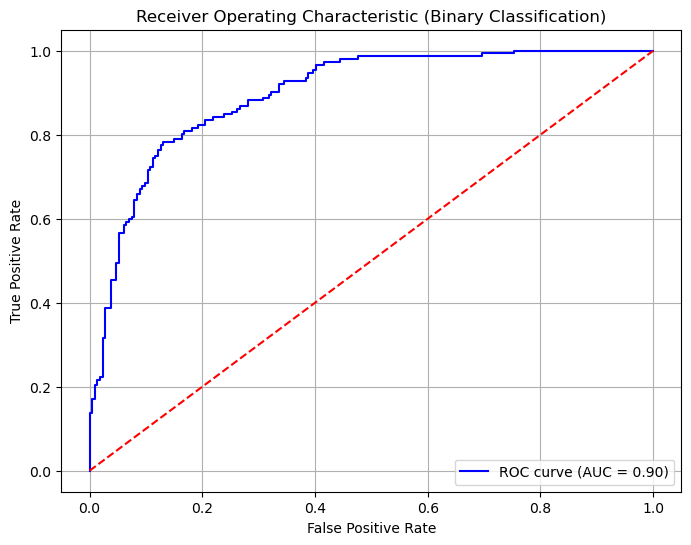

AUC (Binary Classification): 0.90


In [22]:
# ROC Curve (Binary Classification)
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_orig)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.title("Receiver Operating Characteristic (Binary Classification)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"AUC (Binary Classification): {roc_auc:.2f}")

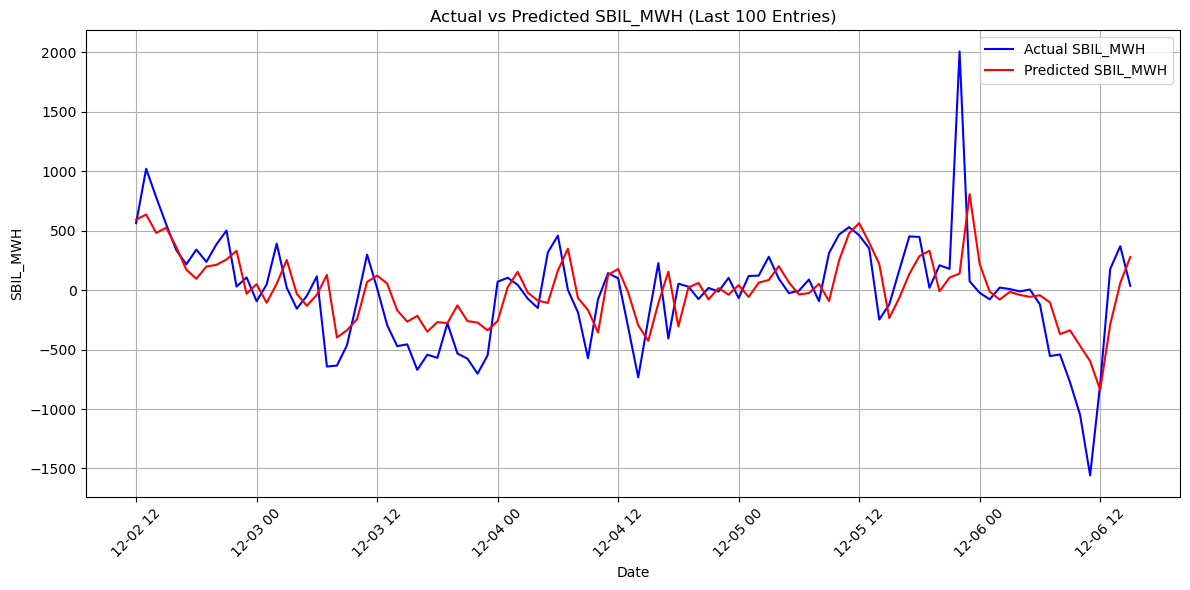

In [23]:
# Actual vs Predicted Plot (Last n Entries)
n = 100
y_test_last_n = scaler_y.inverse_transform(y_test[-n:].reshape(-1, 1)).flatten()
y_pred_last_n = scaler_y.inverse_transform(y_pred[-n:].reshape(-1, 1)).flatten()
dates_last_n = df_nord.index[-n:]

plt.figure(figsize=(12, 6))
plt.plot(dates_last_n, y_test_last_n, label="Actual SBIL_MWH", color="blue")
plt.plot(dates_last_n, y_pred_last_n, label="Predicted SBIL_MWH", color="red")
plt.title("Actual vs Predicted SBIL_MWH (Last 100 Entries)")
plt.xlabel("Date")
plt.ylabel("SBIL_MWH")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<h3> Let's predict the future </h3>

Future DataFrame:
                 Date  Predicted_SBIL_MWH     CI_Lower    CI_Upper
0 2024-12-06 16:00:00          301.904449   -84.515656  688.324585
1 2024-12-06 17:00:00          109.900238   -66.425964  286.226440
2 2024-12-06 18:00:00         -429.416351 -1007.588745  148.756012
3 2024-12-06 19:00:00         -132.617172  -462.978027  197.743698


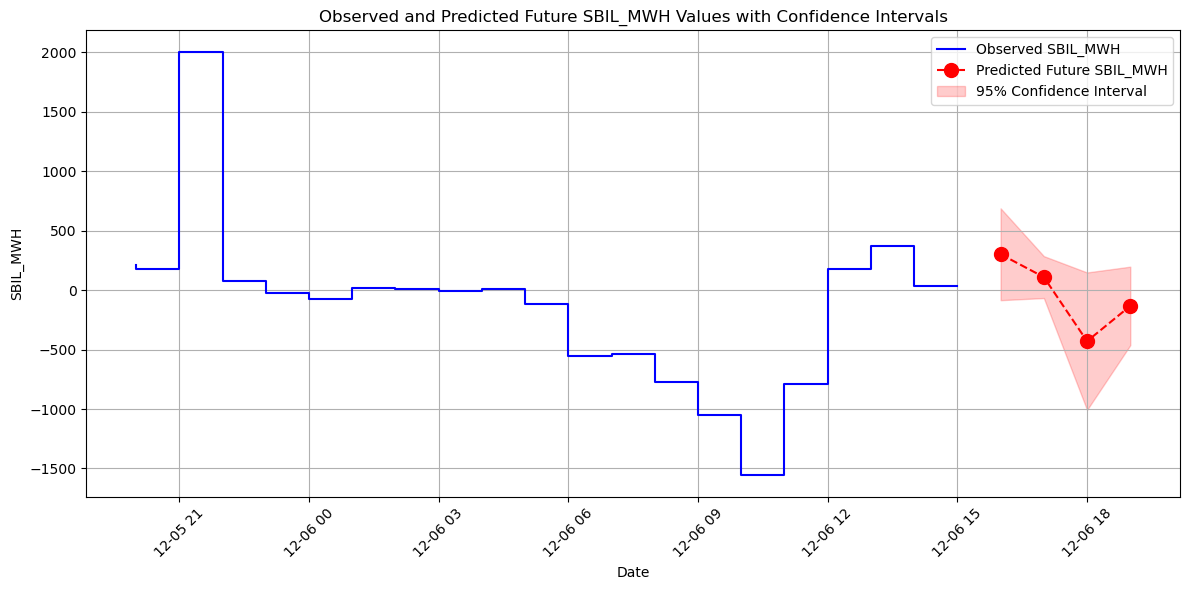

In [24]:
# Number of future steps to predict
n_future_steps = 4  # Predict 4 steps ahead

# Get the last timestamp from the dataset
last_timestamp = df_nord.index[-1]

# Get the most recent data from the test set for the starting point
last_input = X_test[-1].reshape(1, -1)  # Last row from test features

# Placeholder for predictions
predicted_values = []

# Monte Carlo Dropout
n_simulations = 100  # Perform 100 stochastic forward passes
mc_predictions = []  # Placeholder for stochastic predictions

current_input = last_input
for step in range(n_future_steps):
    # Collect multiple stochastic predictions for MC Dropout
    stochastic_results = []
    for _ in range(n_simulations):
        stochastic_pred = model2(current_input, training=True)  # Enable dropout during prediction
        stochastic_results.append(stochastic_pred.numpy().flatten()[0])
    stochastic_results = np.array(stochastic_results)

    # Calculate mean and standard deviation
    mean_prediction = stochastic_results.mean()
    std_prediction = stochastic_results.std()

    # Save the results
    predicted_values.append((mean_prediction, std_prediction))
    mc_predictions.append(stochastic_results)

    # Update the input for the next prediction
    current_input = np.roll(current_input, shift=-1, axis=1)  # Shift all features to the left
    current_input[0, -1] = mean_prediction  # Replace the last feature with the predicted value

# Extract means and standard deviations
predicted_means = [mean for mean, _ in predicted_values]
predicted_stds = [std for _, std in predicted_values]

# Convert to the original scale
predicted_means_orig = scaler_y.inverse_transform(np.array(predicted_means).reshape(-1, 1)).flatten()
predicted_stds_orig = scaler_y.inverse_transform(np.array(predicted_stds).reshape(-1, 1)).flatten()

# Calculate 95% confidence intervals
z_score = 1.96
ci_upper = predicted_means_orig + z_score * predicted_stds_orig
ci_lower = predicted_means_orig - z_score * predicted_stds_orig

# Add 1-hour intervals for the future steps
future_dates = [last_timestamp + pd.Timedelta(hours=i + 1) for i in range(n_future_steps)]

# Create a DataFrame to store the predicted future values
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_SBIL_MWH': predicted_means_orig,
    'CI_Lower': ci_lower,
    'CI_Upper': ci_upper
})

# Debug: Confirm the DataFrame structure
print(f"Future DataFrame:\n{future_df}")

# Plotting
plt.figure(figsize=(12, 6))

# Get the last `n` actual observations (from the test set) for plotting
n_last_obs = 20  # For example, plot the last 20 observed values
last_observed_dates = df_nord.index[-n_last_obs:]  # Get the dates for the last observations
last_observed_values = scaler_y.inverse_transform(y_test[-n_last_obs:].reshape(-1, 1)).flatten()

last_observed_df = pd.DataFrame({
    'Date': last_observed_dates,
    'Actual_SBIL_MWH': last_observed_values
})

# Plot observed values
plt.step(last_observed_df['Date'], last_observed_df['Actual_SBIL_MWH'], label='Observed SBIL_MWH', color='blue')

# Plot predicted values
plt.plot(future_df['Date'], future_df['Predicted_SBIL_MWH'], label='Predicted Future SBIL_MWH', color='red', linestyle='--', marker='o', markersize=10)

# Plot confidence intervals
plt.fill_between(
    future_df['Date'], future_df['CI_Lower'], future_df['CI_Upper'], color='red', alpha=0.2, label='95% Confidence Interval'
)

# Add labels and title
plt.title('Observed and Predicted Future SBIL_MWH Values with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('SBIL_MWH')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()

In [25]:
"""import os
import pandas as pd
from datetime import datetime

# File path for storing predictions
file_path = r'C:\imbalance_forecast\data\df_nord_h_future.csv'

# Step 1: Check if the file exists and is not empty
if os.path.exists(file_path) and os.stat(file_path).st_size > 0:
    # Read the existing DataFrame from the CSV file
    df_existing = pd.read_csv(file_path)
else:
    # If the file does not exist or is empty, create an empty DataFrame with the necessary columns
    df_existing = pd.DataFrame(columns=['Date', 'Predicted_SBIL_MWH_hplus1', 'Predicted_SBIL_MWH_hplus2', 'Run_Timestamp'])

# Step 2: Ensure the columns exist, and if the file is empty, create them
if df_existing.empty:
    df_existing = pd.DataFrame(columns=['Date', 'Predicted_SBIL_MWH_hplus1', 'Predicted_SBIL_MWH_hplus2', 'Run_Timestamp'])

# Step 3: Ensure the 'Date' column is in datetime format for proper comparison
df_existing['Date'] = pd.to_datetime(df_existing['Date'], errors='coerce')

# Step 4: Assign predictions from `future_df` to respective columns
# Assuming `future_df` has predictions for h+1 in row 0 and h+2 in row 1
predicted_hplus1 = future_df.loc[0, 'Predicted_SBIL_MWH']
predicted_hplus2 = future_df.loc[1, 'Predicted_SBIL_MWH']

# Use the timestamp of the h+1 prediction for the new row
run_timestamp = datetime.now()
future_date = future_df.loc[0, 'Date']

# Step 5: Check if the date already exists in `df_existing`
if future_date in df_existing['Date'].values:
    # Update existing row
    df_existing.loc[df_existing['Date'] == future_date, 'Predicted_SBIL_MWH_hplus1'] = predicted_hplus1
    df_existing.loc[df_existing['Date'] == future_date, 'Predicted_SBIL_MWH_hplus2'] = predicted_hplus2
    df_existing.loc[df_existing['Date'] == future_date, 'Run_Timestamp'] = run_timestamp
else:
    # Append a new row with predictions
    new_row = {
        'Date': future_date,
        'Predicted_SBIL_MWH_hplus1': predicted_hplus1,
        'Predicted_SBIL_MWH_hplus2': predicted_hplus2,
        'Run_Timestamp': run_timestamp
    }
    df_existing = pd.concat([df_existing, pd.DataFrame([new_row])], ignore_index=True)

# Step 6: Save the updated DataFrame back to the CSV file
df_existing.to_csv(file_path, index=False)

print("Data successfully appended or updated in the file.")"""


<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\samueledelia\AppData\Local\Temp\3\ipykernel_11268\742278213.py:1: SyntaxWarning: invalid escape sequence '\i'
  """import os


'import os\nimport pandas as pd\nfrom datetime import datetime\n\n# File path for storing predictions\nfile_path = r\'C:\\imbalance_forecast\\data\\df_nord_h_future.csv\'\n\n# Step 1: Check if the file exists and is not empty\nif os.path.exists(file_path) and os.stat(file_path).st_size > 0:\n    # Read the existing DataFrame from the CSV file\n    df_existing = pd.read_csv(file_path)\nelse:\n    # If the file does not exist or is empty, create an empty DataFrame with the necessary columns\n    df_existing = pd.DataFrame(columns=[\'Date\', \'Predicted_SBIL_MWH_hplus1\', \'Predicted_SBIL_MWH_hplus2\', \'Run_Timestamp\'])\n\n# Step 2: Ensure the columns exist, and if the file is empty, create them\nif df_existing.empty:\n    df_existing = pd.DataFrame(columns=[\'Date\', \'Predicted_SBIL_MWH_hplus1\', \'Predicted_SBIL_MWH_hplus2\', \'Run_Timestamp\'])\n\n# Step 3: Ensure the \'Date\' column is in datetime format for proper comparison\ndf_existing[\'Date\'] = pd.to_datetime(df_existing[\'Da